# PyIRI Tutorial: Daily Ionospheric Electron Density Profile Generation and Plotting

This tutorial demonstrates how to use **PyIRI**, a modern, Python-native reformulation of the International Reference Ionosphere (IRI), to:

- Generate ionospheric electron density profile (EDP) parameters at a single location and for an entire day
- Plot the evolution of peak plasma densities, heights, and thicknesses for F2, F1, E, and Es layers
- Visualize the full EDP (electron density vs. height and time)

### Key Features:
- Uses updated IRI coefficients expressed in spherical harmonics and Fourier series
- Supports climatological generation without external dependencies
- Output is based on a specified solar flux index and date

---

### Requirements
Make sure you have the following PyIRI modules:
- `PyIRI.sh_library`
- `PyIRI.edp_update`

In [1]:
# Import libraries
import numpy as np
import PyIRI
import PyIRI.edp_update as ml  # Legacy PyIRI formalism (Fourier + empirical)
import PyIRI.sh_library as sh  # Updated PyIRI using spherical harmonics
import matplotlib.pyplot as plt

# Specify date
year = 2020
month = 4
day = 1

# Specify solar activity index (F10.7 in SFU)
F107 = 100

# Select base coefficient set: 0 = CCIR, 1 = URSI
ccir_or_ursi = 0

# Location of interest: 10°E, 20°N
alon = np.array([10.])
alat = np.array([20.])

# Time grid: Universal Time from 0 to 24 in 15-minute steps
hr_res = 0.25
aUT = np.arange(0, 24, hr_res)

# Height grid: 90 km to 700 km in 1 km steps
alt_res = 1
alt_min = 90
alt_max = 700
aalt = np.arange(alt_min, alt_max, alt_res)

# Coefficient sources and model options
foF2_coeff = 'CCIR'       # Options: 'CCIR' or 'URSI'
hmF2_model = 'SHU2015'    # Options: 'SHU2015', 'AMTB2013', 'BSE1979'
coord = 'GEO'             # Coordinate system: 'GEO', 'QD', or 'MLT'
coeff_dir = None          # Use default coefficient path

# ----------------------------------------
# Run PyIRI (Spherical Harmonics version)
# ----------------------------------------
# Compute ionospheric parameters for F2, F1, and E layers
(F2,
 F1,
 E,
 sun,
 mag,
 EDP) = sh.IRI_density_1day(year,
                            month,
                            day,
                            aUT,
                            alon,
                            alat,
                            aalt,
                            F107,
                            coeff_dir=coeff_dir,
                            foF2_coeff=foF2_coeff,
                            hmF2_model=hmF2_model,
                            coord=coord)

# Compute parameters for the sporadic E (Es) layer
Es = sh.sporadic_E_1day(year,
                        month,
                        day,
                        aUT,
                        alon,
                        alat,
                        F107,
                        coeff_dir=coeff_dir,
                        coord=coord)


### Plot results

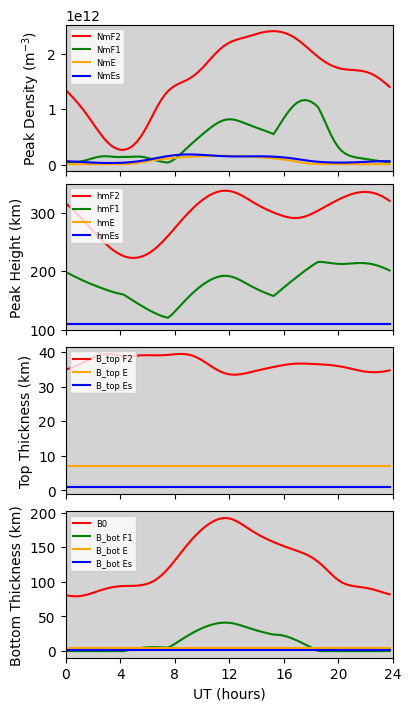

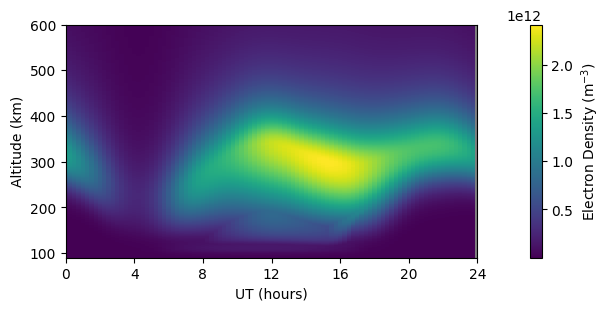

In [2]:
# Plot results for F2 region at time stamp UT=10
# Make sure alon and alat contains lon_plot and lat_plot
# Define location for plotting
lon_plot = 10
lat_plot = 20

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(4, 7), constrained_layout=True)
plt.xlim([0, 24])
plt.xticks(np.arange(0, 24 + 4, 4))
ind_grid = np.where((alon == lon_plot) & (alat == lat_plot))[0]

# Panel 1: Peak Electron Densities
ax_plot = ax[0]
ax_plot.set_facecolor('lightgrey')
ax_plot.set_ylabel('Peak Density (m$^{-3}$)')
ax_plot.plot(aUT, F2['Nm'][:, ind_grid], label='NmF2', c='red')
ax_plot.plot(aUT, F1['Nm'][:, ind_grid], label='NmF1', c='green')
ax_plot.plot(aUT, E['Nm'][:, ind_grid], label='NmE', c='orange')
ax_plot.plot(aUT, Es['Nm'][:, ind_grid], label='NmEs', c='blue')
ax_plot.legend(loc='upper left', prop={'size': 6})

# Panel 2: Peak Heights
ax_plot = ax[1]
ax_plot.set_facecolor('lightgrey')
ax_plot.set_ylabel('Peak Height (km)')
ax_plot.plot(aUT, F2['hm'][:, ind_grid], label='hmF2', c='red')
ax_plot.plot(aUT, F1['hm'][:, ind_grid], label='hmF1', c='green')
ax_plot.plot(aUT, E['hm'][:, ind_grid], label='hmE', c='orange')
ax_plot.plot(aUT, Es['hm'][:, ind_grid], label='hmEs', c='blue')
ax_plot.legend(loc='upper left', prop={'size': 6})

# Panel 3: Topside Thickness
ax_plot = ax[2]
ax_plot.set_facecolor('lightgrey')
ax_plot.set_ylabel('Top Thickness (km)')
ax_plot.plot(aUT, F2['B_top'][:, ind_grid], label='B_top F2', c='red')
ax_plot.plot(aUT, E['B_top'][:, ind_grid], label='B_top E', c='orange')
ax_plot.plot(aUT, Es['B_top'][:, ind_grid], label='B_top Es', c='blue')
ax_plot.legend(loc='upper left', prop={'size': 6})

# Panel 4: Bottomside Thickness
ax_plot = ax[3]
ax_plot.set_facecolor('lightgrey')
ax_plot.set_xlabel('UT (hours)')
ax_plot.set_ylabel('Bottom Thickness (km)')
ax_plot.plot(aUT, F2['B0'][:, ind_grid], label='B0', c='red')
ax_plot.plot(aUT, F1['B_bot'][:, ind_grid], label='B_bot F1', c='green')
ax_plot.plot(aUT, E['B_bot'][:, ind_grid], label='B_bot E', c='orange')
ax_plot.plot(aUT, Es['B_top'][:, ind_grid], label='B_bot Es', c='blue')
ax_plot.legend(loc='upper left', prop={'size': 6})

# Save figure
plot_dir = '../figures/'
plt.savefig(plot_dir + 'PyIRI_sh_diurnal.png', format='pdf', bbox_inches='tight')

# Plot electron density as a function of time
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
plt.xlim([0, 24])
plt.ylim([90, 600])
plt.xticks(np.arange(0, 24 + 4, 4))
ax.set_facecolor('grey')
ax.set_xlabel('UT (hours)')
ax.set_ylabel('Altitude (km)')
ind_grid = np.where((alon == lon_plot) & (alat == lat_plot))[0]
z = np.transpose(np.reshape(EDP[:, :, ind_grid], (aUT.size, aalt.size)))
mesh = ax.pcolormesh(aUT, aalt, z)
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('Electron Density (m$^{-3}$)')

# Save figure
plot_dir = '../figures/'
plt.savefig(plot_dir + 'PyIRI_sh_EDP_diurnal.png', format='pdf', bbox_inches='tight')




### Run legacy PyIRI formalism (Fourier + empirical)

In [3]:
# Select base coefficient set: 0 = CCIR, 1 = URSI
ccir_or_ursi = 0

# Run legacy PyIRI model based on v0.0.4 to get ionospheric layers and electron density profile (EDP)
F2, F1, E, Es, sun, mag, EDP = ml.IRI_density_1day(
    year, month, day,
    aUT, alon, alat, aalt,
    F107, PyIRI.coeff_dir, ccir_or_ursi
)

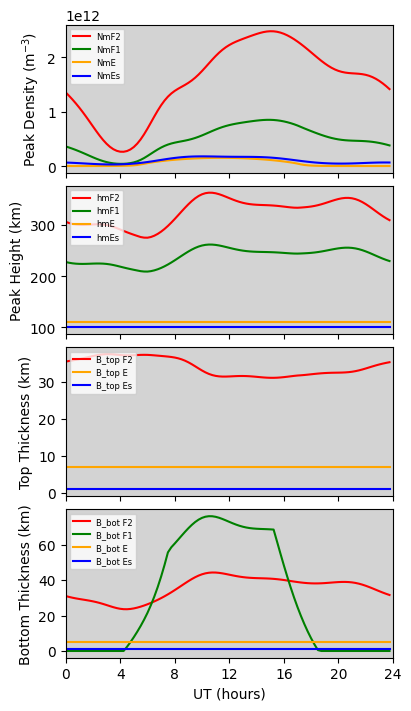

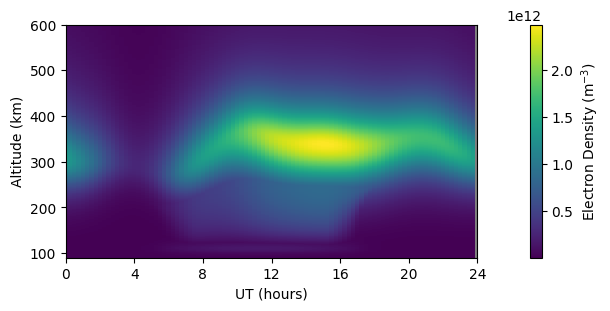

In [4]:
# Plot results for F2 region at time stamp UT=10
# Make sure alon and alat contains lon_plot and lat_plot
# Define location for plotting
lon_plot = 10
lat_plot = 20

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(4, 7), constrained_layout=True)
plt.xlim([0, 24])
plt.xticks(np.arange(0, 24 + 4, 4))
ind_grid = np.where((alon == lon_plot) & (alat == lat_plot))[0]

# Panel 1: Peak Electron Densities
ax[0].set_facecolor('lightgrey')
ax[0].set_ylabel('Peak Density (m$^{-3}$)')
ax[0].plot(aUT, F2['Nm'][:, ind_grid], label='NmF2', c='red')
ax[0].plot(aUT, F1['Nm'][:, ind_grid], label='NmF1', c='green')
ax[0].plot(aUT, E['Nm'][:, ind_grid], label='NmE', c='orange')
ax[0].plot(aUT, Es['Nm'][:, ind_grid], label='NmEs', c='blue')
ax[0].legend(loc='upper left', prop={'size': 6})

# Panel 2: Peak Heights
ax[1].set_facecolor('lightgrey')
ax[1].set_ylabel('Peak Height (km)')
ax[1].plot(aUT, F2['hm'][:, ind_grid], label='hmF2', c='red')
ax[1].plot(aUT, F1['hm'][:, ind_grid], label='hmF1', c='green')
ax[1].plot(aUT, E['hm'][:, ind_grid], label='hmE', c='orange')
ax[1].plot(aUT, Es['hm'][:, ind_grid], label='hmEs', c='blue')
ax[1].legend(loc='upper left', prop={'size': 6})

# Panel 3: Topside Thickness
ax[2].set_facecolor('lightgrey')
ax[2].set_ylabel('Top Thickness (km)')
ax[2].plot(aUT, F2['B_top'][:, ind_grid], label='B_top F2', c='red')
ax[2].plot(aUT, E['B_top'][:, ind_grid], label='B_top E', c='orange')
ax[2].plot(aUT, Es['B_top'][:, ind_grid], label='B_top Es', c='blue')
ax[2].legend(loc='upper left', prop={'size': 6})

# Panel 4: Bottomside Thickness
ax[3].set_facecolor('lightgrey')
ax[3].set_xlabel('UT (hours)')
ax[3].set_ylabel('Bottom Thickness (km)')
ax[3].plot(aUT, F2['B_bot'][:, ind_grid], label='B_bot F2', c='red')
ax[3].plot(aUT, F1['B_bot'][:, ind_grid], label='B_bot F1', c='green')
ax[3].plot(aUT, E['B_bot'][:, ind_grid], label='B_bot E', c='orange')
ax[3].plot(aUT, Es['B_top'][:, ind_grid], label='B_bot Es', c='blue')
ax[3].legend(loc='upper left', prop={'size': 6})

# Save figure
plot_dir = '../figures/'
plt.savefig(plot_dir + 'PyIRI_legacy_diurnal.png', format='pdf', bbox_inches='tight')

# Plot electron density as a function of time
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
plt.xlim([0, 24])
plt.ylim([90, 600])
plt.xticks(np.arange(0, 24 + 4, 4))
ax.set_facecolor('grey')
ax.set_xlabel('UT (hours)')
ax.set_ylabel('Altitude (km)')
ind_grid = np.where((alon == lon_plot) & (alat == lat_plot))[0]
z = np.transpose(np.reshape(EDP[:, :, ind_grid], (aUT.size, aalt.size)))
mesh = ax.pcolormesh(aUT, aalt, z)
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('Electron Density (m$^{-3}$)')

# Save figure
plot_dir = '../figures/'
plt.savefig(plot_dir + 'PyIRI_legacy_EDP_diurnal.png', format='pdf', bbox_inches='tight')